## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn import preprocessing

## LOADING & EXPLORING DATA

1- bookID count shows 11127 rows (describe function) but highest bookID is 45641 (= it is an ID number, not a count)

2- removed unwanted commas separating several authors in Author column. As only 4 books were concerned it was done manually.

3- noticed special characters (jpn, chn, ar) in the authors names : no matter as this column author, although relevant, shall be removed due to difficulties in selecting the "right" author to work on for rating influence

4- isbn column: 

    - should be 10-digit long as "isbn10" standard number (before 2007)
    
    - a large number of rows have 7, 8, 9 digits or even 10 with an X at the end: should be dropped as it does not bring much help for our purpose 

5- isbn13 column (REFERENCE number since 2007):

    - should be 13-digit long as "isbn13" standard number

    - 10, 11 digit number --> should be dropped as it does not bring much help for our purpose 

6- "language code": english in 4 or 5 different versions (eg: en-GB, en-US, etc.): MAY NEED GROUPING BOOKS IN ENGLISH OR CREATE CATEGORIES TO IMPROVE PREDICTION (LIKE ENGLISH VS OTHER LANGUAGES)

7- "num_pages": books from 0 up to 6576 pages --> NEED FILTERING (as potential non-relevant outliers) BY DEFINING A "MIN/MAX NUM_PAGES" OR CREATE CATEGORIES TO IMPROVE PREDICTION

8- "Ratings count": from 0 to ~4.6M // MAY NEED TO FILTER OUT AT LEAST COUNTS 0, OR TAKE INTO ACCOUNT A "MIN RATING COUNT" OR CREATE CATEGORIES TO IMPROVE PREDICTION

9- "text_reviews count": from 0 to 94265 // SAME: MAY NEED TO FILTER OUT AT LEAST COUNTS 0, OR TAKE INTO ACCOUNT A "MIN REVIEWS COUNT" OR CREATE CATEGORIES TO IMPROVE PREDICTION

10- publication_date: US format / and 2 invalid dates (nov31 and jun31 do not exist, hence not recognized by excel as "actual dates") // SUCH DATE FOR PREDICTION DOES NOT SEEM USEFUL HERE 

11- publisher: "18-Oct" for 2 entries seems odd: actually a publisher called "10/18" (ref: https://www.goodreads.com/shelf/show/editeurs-10-18)


### importing data

In [2]:
df = pd.read_csv(r"C:\Users\33695\Documents\ML with Python\Project-20230605\Project 1\dataset\books_jul6.csv", delimiter=",", index_col="bookID")

In [3]:
print(f"The data contains {df.shape[0]} Rows and {df.shape[1]} Columns")

The data contains 11127 Rows and 11 Columns


In [ ]:
df.head(10)

## data exploration

In [4]:
# basic stats on numeric only data 
df.describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498
std,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608
min,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,3.770000,9.780350e+12,192.000000,1.040000e+02,9.000000
50%,3.960000,9.780590e+12,299.000000,7.450000e+02,46.000000
75%,4.135000,9.780870e+12,416.000000,4.993500e+03,237.500000
max,5.000000,9.790010e+12,6576.000000,4.597666e+06,94265.000000


df.describe treats isbn13 as a number.
however, does not display bookID nor isbn

Also: a total count of 11127 books are listed (note that 10544 are of "en" language code)

In [ ]:
# langage_code: list all rows containing "en"
s_lang = df.language_code
val_lang = ['en-CA','eng','en-GB','enm','en-US']
df[s_lang.isin(val_lang)].shape

NOTE: this latter listing showed 10544 rows containing "en" in the language code column

### search for inconsistencies

In [ ]:
# look for "NA" values
df.isna().sum()

In [ ]:
# isbn13 is not NA?
df.isnull().sum()

data set does not show missing or null values

### first approach of the problem: Distributions
How are the different features distributed?
Books rating as a continuous or categorical variable?
How to define influent features?

In [5]:
# type of data in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11127 non-null  object 
 1   authors             11127 non-null  object 
 2   average_rating      11127 non-null  float64
 3   isbn                11127 non-null  object 
 4   isbn13              11127 non-null  int64  
 5   language_code       11127 non-null  object 
 6   num_pages           11127 non-null  int64  
 7   ratings_count       11127 non-null  int64  
 8   text_reviews_count  11127 non-null  int64  
 9   publication_date    11127 non-null  object 
 10  publisher           11127 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.0+ MB


5 variables are numeric , 6 are of dtype 'object' (7 with BookID)

In [6]:
#df.average_rating.value_counts() # distribution / frequency of the "average_rating"
df.iloc[:,2].describe() 

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

### COMMENTS
1) AVERAGE RATING OF EACH BOOK_ID REFLECTS AN ACTUAL DISTRIBUTION... HOWEVER, WE DO NOT KNOW ITS NATURE (MIN, MAX, STDEV FOR EACH BOOK ID)

2) AVERAGE RATING "DESCRIBE()" showed MEDIAN=3.96

3) find outliers in other columns (rating, num_pages, ratings_count, text_reviews)

4) filter data for more accurate prediction (ratings_count >100, num_pages btw 100 and 500)

5) consider including other columns (convert to numeric? 0 or 1 value? other?)

In [ ]:
# get_dummies tranforms categorical data to numbers
# here we want to transform the "Sex" column from ['male', 'female'] to [0,1]
# Ex: df_processed.loc[:,["Sex"]] = pd.get_dummies(df.Sex,drop_first=True).values

In [ ]:
# this is a way to explicit the "Pclass" column by transforming it to 3 columns corresponding to each of its values
# this is known as encoding
# df_processed = pd.concat([df_processed,pd.get_dummies(df_processed.Pclass)],axis=1).drop(columns="Pclass")

<function matplotlib.pyplot.show(close=None, block=None)>

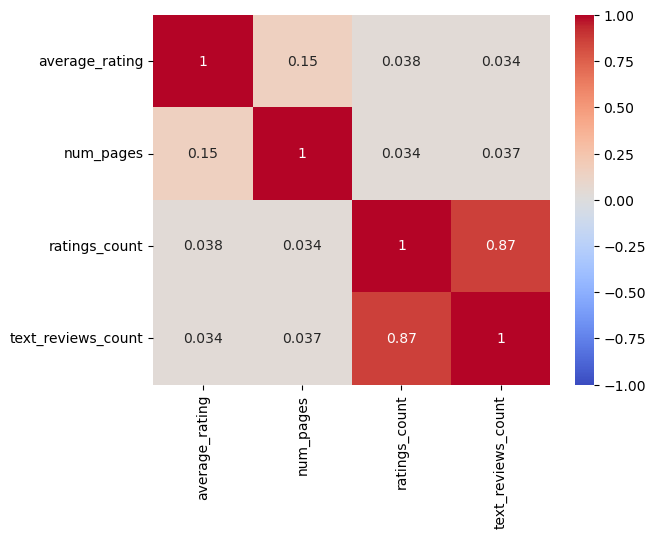

In [7]:
# PLOT CORRELATION ANALYSIS
df_corr = df[["average_rating", "num_pages","ratings_count", "text_reviews_count"]]
# corr = df_corr.corr()
corr1 = df_corr.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show

almost no correlation between average_rating and other features

only ratings_count correlates well with text_reviews_count


In [ ]:
pd.plotting.scatter_matrix(df_corr, figsize=(8,8), marker="o")
plt.show()

scatter matrix shows various distibutions

average_rating auto-correlation plot shows a majority of rating 4 (around 4)

also: almost no small ratings (between 0 and 3): THEREFORE THERE IS AN IMBALANCE IN THE ATTRIBUTED RATINGS (most people gave rather high ratings)


In [ ]:
# now plot rating to show imbalance
plt.bar(x=df.average_rating.value_counts().index,height=df.average_rating.value_counts())
plt.show()

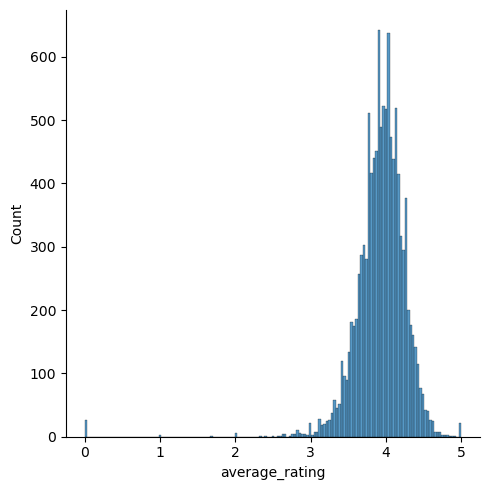

In [8]:
# draw distribution of ratings
sns.displot(df.average_rating)

#### --> Average rating seems to be normal distribution

### Plotting normalized values on '0-1' scale for: average_rating (1), num_pages (2), ratings_count (3), reviews_count (4)

<function matplotlib.pyplot.show(close=None, block=None)>

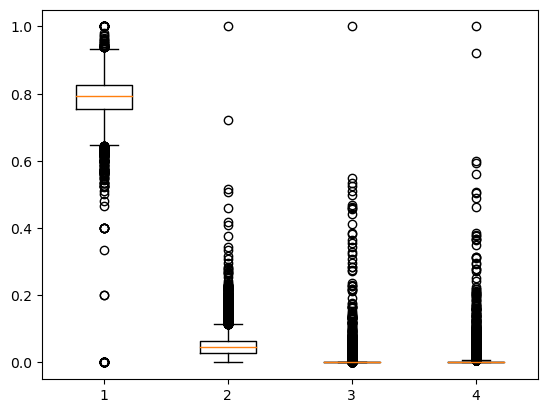

In [9]:
normalizedVars = df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].values.astype(float)
#myUnitScale = preprocessing.MinMaxScaler()
myNormVar=preprocessing.MinMaxScaler().fit_transform(normalizedVars)
plt.boxplot(myNormVar)
plt.show

spread of data and outliers are shown above

may need to focus analysis on specific ranges

### Categorical data

In [ ]:
df.language_code.value_counts() # distribution / frequency of the classes "language_code"

In [10]:
catcols = ['title', 'authors', 'isbn', 'language_code','publication_date','publisher']
df[catcols].describe()

,title,authors,isbn,language_code,publication_date,publisher
count,11127,11127,11127,11127,11127,11127
unique,10352,6643,11127,27,3679,2292
top,The Brothers Karamazov,Stephen King,439785960,eng,10/1/2005,Vintage
freq,9,40,1,8911,56,318


In [11]:
df.loc[df.title=='The Brothers Karamazov',:].average_rating.describe()

count    9.00
mean     4.32
std      0.00
min      4.32
25%      4.32
50%      4.32
75%      4.32
max      4.32
Name: average_rating, dtype: float64

In [12]:
df.loc[df.authors=='Stephen King',:].average_rating.describe()

count    40.000000
mean      3.973500
std       0.270067
min       3.320000
25%       3.882500
50%       3.965000
75%       4.175000
max       4.540000
Name: average_rating, dtype: float64

In [13]:
df.loc[df.publisher=='Vintage',:].average_rating.describe()

count    318.000000
mean       3.894182
std        0.259305
min        2.790000
25%        3.750000
50%        3.910000
75%        4.077500
max        4.530000
Name: average_rating, dtype: float64

top book is "the brothers Karamazov"

top author Stephen King

most cited publisher = Vintage

## Clean and structure data

### COMMENTS

1) Average Rating "describe()" showed MEDIAN=3.96 (~normal distribution)

2) Creating low medium high rating class ??

3) Strong Correlation btw ratings_count and reviews_count : DROP REVIEWS?

3) deal with outliers in other columns (rating, num_pages, text_reviews)

4) consider including categorical data for more accurate prediction (to sort / encode)

In [14]:
# df1_processed['average_rating'] = df1_processed['average_rating'].astype('int')
df1=df.drop(columns=['text_reviews_count'])

In [ ]:
df1.average_rating.describe() # 

### Create low, med, high categories for average_rating

In [131]:
# group_name: upper bound
groups = {'0LOW': 0, '1MEDIUM': 2, '2HIGH': 4}
df1['R_Type'] = pd.cut(df1['average_rating'], right = False,
                    bins=list(groups.values())+[float('inf')],
                    labels=list(groups),include_lowest = True
                   )
#bins = np.linspace(min(df1['average_rating']), max(df1['average_rating']),4)
#groupNames = ["low", "med", "high"]
#df1['RatingCat'] = pd.cut(df1['average_rating'], bins, labels = groupNames, include_lowest = True)

In [73]:
df1['R_Type'].describe()

count       11127
unique          3
top       1MEDIUM
freq         4749
Name: R_Type, dtype: object

In [132]:
df1['R_Type'].value_counts()

1MEDIUM    6144
2HIGH      4954
0LOW         29
Name: R_Type, dtype: int64

In [75]:
df1.shape

(11127, 11)

In [ ]:
df1.describe()

In [133]:
myLabel = preprocessing.LabelEncoder()
df1['R_Type'] = myLabel.fit_transform(df1['R_Type'])

In [ ]:
df1.tail()

In [134]:
df1['R_Type'].value_counts()

1    6144
2    4954
0      29
Name: R_Type, dtype: int64

In [79]:
df1[df1['R_Type']==0].describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,3049.000000,3.049000e+03,3049.000000,3.049000e+03,3049.0
mean,3.552686,9.756482e+12,292.227944,1.115412e+04,0.0
std,0.396381,4.761726e+11,162.380627,1.061688e+05,0.0
min,0.000000,2.004913e+10,0.000000,0.000000e+00,0.0
25%,3.500000,9.780340e+12,191.000000,6.000000e+01,0.0
50%,3.640000,9.780550e+12,272.000000,4.260000e+02,0.0
75%,3.730000,9.780870e+12,368.000000,2.948000e+03,0.0
max,3.790000,9.789880e+12,1440.000000,4.597666e+06,0.0


In [80]:
df1[df1['R_Type']==1].describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,4749.000000,4.749000e+03,4749.000000,4.749000e+03,4749.0
mean,3.948273,9.763387e+12,326.732575,1.910365e+04,1.0
std,0.084722,4.006307e+11,190.659936,1.030049e+05,0.0
min,3.800000,2.375500e+10,0.000000,0.000000e+00,1.0
25%,3.880000,9.780350e+12,205.000000,1.510000e+02,1.0
50%,3.950000,9.780550e+12,304.000000,9.770000e+02,1.0
75%,4.020000,9.780810e+12,416.000000,6.114000e+03,1.0
max,4.090000,9.789870e+12,1952.000000,2.457092e+06,1.0


In [81]:
df1[df1['R_Type']==2].describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,3329.000000,3.329000e+03,3329.000000,3.329000e+03,3329.0
mean,4.261646,9.758016e+12,390.570742,2.248312e+04,2.0
std,0.142314,4.680790e+11,336.914868,1.295027e+05,0.0
min,4.100000,8.987060e+09,0.000000,0.000000e+00,2.0
25%,4.160000,9.780380e+12,192.000000,1.150000e+02,2.0
50%,4.230000,9.780680e+12,320.000000,8.110000e+02,2.0
75%,4.330000,9.781400e+12,496.000000,5.745000e+03,2.0
max,5.000000,9.790010e+12,6576.000000,2.530894e+06,2.0


### Top 10 Books that received more ratings

In [ ]:
# Let's look at the top 10 rated books
top10Books = df1.nlargest(10, ['ratings_count']).set_index('title')['ratings_count']
plot_dims = (12, 8)
fig, ax = plt.subplots(figsize=plot_dims)
sns.barplot(x=top10Books, y=top10Books.index)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 15, color = 'k')
    
plt.show()

### Top 10 book titles with most number of pages

In [ ]:
# Let's look at the top 10 books in terms of number of pages
top10Books2 = df1.nlargest(10, ['num_pages']).set_index('title')['num_pages']
plot_dims = (12, 8)
fig, ax = plt.subplots(figsize=plot_dims)
sns.barplot(x=top10Books2, y=top10Books2.index)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 15, color = 'k')
    
plt.show()

### Average_ratings vs num_pages

In [ ]:
# plot avg rating vs num pages
plt.figure(figsize=(10,5))
plt.scatter(df1.R_Type,df.num_pages)
plt.title("Rtype vs numPages")
plt.xlabel("Rtype")
plt.ylabel("numPages")
plt.show()

In [ ]:
sns.histplot(x="num_pages",hue="R_Type",multiple="stack",data=df1)
plt.show()

In [ ]:
NormNumPage = df1.num_pages / max(df1.num_pages)
NormRatingCnt = df1.ratings_count / max(df1.ratings_count)
#sns.jointplot(data=df1, x="num_pages", y="ratings_count", hue="R_Type") 

In [ ]:
sns.jointplot(data=df1, x=NormNumPage, y=NormRatingCnt, hue="R_Type") 

In [ ]:
mydf=df1.drop(columns=['isbn13'])

In [ ]:
mydf['NormNumPage']=NormNumPage

In [ ]:
mydf['NormRatingCnt']=NormRatingCnt

In [ ]:
mydf=mydf.drop(columns=['num_pages', 'ratings_count'])

In [ ]:
mydf.describe()

In [ ]:
sns.pairplot(data=mydf, hue="R_Type")

### Language Code sorting

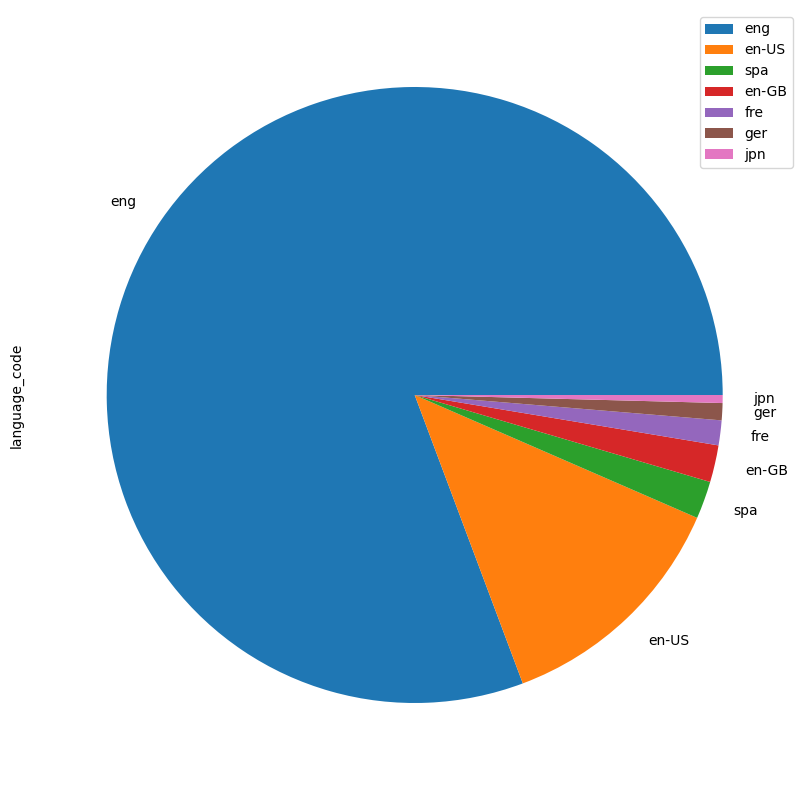

In [24]:
df1['language_code'].value_counts().head(7).plot(kind = 'pie', figsize=(10, 10)).legend()
plt.show()

In [82]:
df_LangCode = df1.loc[df1['language_code'].isin(['eng','en-US', 'spa', 'en-GB', 'fre'])] 
df_LangCode.shape

(10896, 11)

### Creating rating_count two samples based on LangCode subset
1. Assume high ratings count as >= 100,000
2. 'ratings_count' - Drop ratings below 100, 000

In [83]:
# books that are counted as having more than 100000 ratings
High_Rating = 100000
df_HighRatedBooks = df_LangCode.drop(df_LangCode.index[df_LangCode['ratings_count'] <= High_Rating])

In [84]:
df_HighRatedBooks.shape

(352, 11)

In [85]:
## books that are counted as having less than 100000 ratings
df_OtherBooks = df_LangCode.drop(df_LangCode.index[df_LangCode['ratings_count'] > High_Rating])

In [86]:
df_OtherBooks.shape

(10544, 11)

In [30]:
df_OtherBooks.describe()

,average_rating,isbn13,num_pages,ratings_count,R_Type
count,10544.000000,1.054400e+04,10544.000000,10544.000000,10544.000000
mean,3.928154,9.758672e+12,334.268304,6035.777599,0.877561
std,0.351584,4.549458e+11,241.578774,13905.244222,0.831362
min,0.000000,8.987060e+09,0.000000,0.000000,0.000000
25%,3.770000,9.780350e+12,192.000000,106.000000,0.000000
50%,3.950000,9.780570e+12,296.000000,701.000000,1.000000
75%,4.130000,9.780850e+12,416.000000,4223.250000,2.000000
max,5.000000,9.790010e+12,6576.000000,99076.000000,2.000000


## Encoding the Categorical variables for the two samples

### a. Encode the 'title' (label encoding --> numbers)

#### Encoding samples in df_HighRatedBooks and df_OtherBooks:

In [88]:
# encode title column
labelEncode = preprocessing.LabelEncoder()
df_HighRatedBooks['title'] = labelEncode.fit_transform(df_HighRatedBooks['title'])
df_OtherBooks['title'] = labelEncode.fit_transform(df_OtherBooks['title'])

In [ ]:
df_HighRatedBooks.head()

In [ ]:
df_OtherBooks.head()

### b. Encode the 'authors'  (label encoding --> numbers)

#### Encoding samples in df_HighRatedBooks and df_OtherBooks

In [89]:
# encode authors column
df_HighRatedBooks['authors'] = labelEncode.fit_transform(df_HighRatedBooks['authors'])
df_HighRatedBooks.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type
bookID,,,,,,,,,,,
1,98,90,4.57,439785960,9780440000000,eng,652,2095690,9/16/2006,Scholastic Inc.,2
2,99,90,4.49,439358078,9780440000000,eng,870,2153167,9/1/2004,Scholastic Inc.,2
5,100,90,4.56,043965548X,9780440000000,eng,435,2339585,5/1/2004,Scholastic Inc.,2
13,313,55,4.38,345453743,9780350000000,eng,815,249558,4/30/2002,Del Rey Books,2
21,19,26,4.21,076790818X,9780770000000,eng,544,248558,9/14/2004,Broadway Books,2


In [90]:
df_OtherBooks['authors'] = labelEncode.fit_transform(df_OtherBooks['authors'])
df_OtherBooks.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,,,,,,
4,2926,2546,4.42,439554896,9780440000000,eng,352,6333,11/1/2003,Scholastic,2,0,0,1,0,0
8,2921,2548,4.78,439682584,9780440000000,eng,2690,41428,9/13/2004,Scholastic,2,0,0,1,0,0
9,9326,6121,3.74,976540606,9780980000000,en-US,152,19,4/26/2005,Nimble Books,0,0,1,0,0,0
10,2922,2546,4.73,439827604,9780440000000,eng,3342,28242,9/12/2005,Scholastic,2,0,0,1,0,0
12,8769,1431,4.38,517226952,9780520000000,eng,815,3628,11/1/2005,Gramercy Books,2,0,0,1,0,0


### c. Dummy encode the 'language_code' (one-hot encoding --> vectors)

#### Encoding samples in df_HighRatedBooks

In [91]:
encoded_lang_high = pd.get_dummies(df_HighRatedBooks['language_code'])
colsExist2 = df_HighRatedBooks.columns.isin(['en-US', 'eng', 'en-GB', 'fre', 'spa']).any()
if  colsExist2 == False:
    df_HighRatedBooks = pd.concat([df_HighRatedBooks, encoded_lang_high], axis = 1)
print(df_HighRatedBooks.shape)
df_HighRatedBooks.head()

(352, 16)


,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,,,,,,
1,98,90,4.57,439785960,9780440000000,eng,652,2095690,9/16/2006,Scholastic Inc.,2,0,0,1,0,0
2,99,90,4.49,439358078,9780440000000,eng,870,2153167,9/1/2004,Scholastic Inc.,2,0,0,1,0,0
5,100,90,4.56,043965548X,9780440000000,eng,435,2339585,5/1/2004,Scholastic Inc.,2,0,0,1,0,0
13,313,55,4.38,345453743,9780350000000,eng,815,249558,4/30/2002,Del Rey Books,2,0,0,1,0,0
21,19,26,4.21,076790818X,9780770000000,eng,544,248558,9/14/2004,Broadway Books,2,0,0,1,0,0


#### Encoding samples in df_OtherBooks

In [92]:
encoded_lang_other = pd.get_dummies(df_OtherBooks['language_code'])
encoded_lang_other.head()
colsExist = df_OtherBooks.columns.isin(['en-US', 'en-GB', 'eng', 'fre', 'spa']).any()
if  colsExist == False:
    df_OtherBooks = pd.concat([df_OtherBooks, encoded_lang_other], axis = 1)
print(df_OtherBooks.shape)
df_OtherBooks.head()

(10544, 16)


,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,publication_date,publisher,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,,,,,,
4,2926,2546,4.42,439554896,9780440000000,eng,352,6333,11/1/2003,Scholastic,2,0,0,1,0,0
8,2921,2548,4.78,439682584,9780440000000,eng,2690,41428,9/13/2004,Scholastic,2,0,0,1,0,0
9,9326,6121,3.74,976540606,9780980000000,en-US,152,19,4/26/2005,Nimble Books,0,0,1,0,0,0
10,2922,2546,4.73,439827604,9780440000000,eng,3342,28242,9/12/2005,Scholastic,2,0,0,1,0,0
12,8769,1431,4.38,517226952,9780520000000,eng,815,3628,11/1/2005,Gramercy Books,2,0,0,1,0,0


## Model selection (next) - refer "titanic project"

In [93]:
# create subset df_processed for numeric data only & drop unused columns 
df_HighRatedBooks = df_HighRatedBooks.drop(columns=["average_rating", "isbn","language_code", "publication_date","publisher"])

In [94]:
df_HighRatedBooks

,title,authors,isbn13,num_pages,ratings_count,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,
1,98,90,9780440000000,652,2095690,2,0,0,1,0,0
2,99,90,9780440000000,870,2153167,2,0,0,1,0,0
5,100,90,9780440000000,435,2339585,2,0,0,1,0,0
13,313,55,9780350000000,815,249558,2,0,0,1,0,0
21,19,26,9780770000000,544,248558,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
43763,112,11,9780350000000,342,433413,1,0,0,1,0,0
43814,316,11,9780350000000,481,156354,1,0,0,1,0,0
43889,345,229,9780770000000,836,204648,2,0,0,1,0,0


In [95]:
df_HighRatedBooks['R_Type'].value_counts()

1    157
2    139
0     56
Name: R_Type, dtype: int64

In [96]:
# create subset df_processed for numeric data only & drop unused columns 
df_OtherBooks = df_OtherBooks.drop(columns=["average_rating", "isbn","language_code", "publication_date","publisher"])

In [ ]:
df_OtherBooks

In [97]:
df_OtherBooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10544 entries, 4 to 45641
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   title          10544 non-null  int32
 1   authors        10544 non-null  int32
 2   isbn13         10544 non-null  int64
 3   num_pages      10544 non-null  int64
 4   ratings_count  10544 non-null  int64
 5   R_Type         10544 non-null  int32
 6   en-GB          10544 non-null  uint8
 7   en-US          10544 non-null  uint8
 8   eng            10544 non-null  uint8
 9   fre            10544 non-null  uint8
 10  spa            10544 non-null  uint8
dtypes: int32(3), int64(3), uint8(5)
memory usage: 504.5 KB


In [98]:
df_OtherBooks['R_Type'].value_counts()

1    4518
2    3077
0    2949
Name: R_Type, dtype: int64

### Model selection

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
# " define (randomly) training and testing dataframe"
df_train_other, df_test_other = train_test_split(df_OtherBooks,test_size = 0.2, stratify = df_OtherBooks.R_Type)

In [101]:
len(df_OtherBooks)

10544

In [102]:
len(df_train_other)

8435

In [103]:
len(df_test_other)

2109

In [ ]:
# option to write a function to apply model
'''
def ModelBuilding_LogisticRegression(df_Current, testSize=0.2):
    # divide the data into attributes and labels
    X = df_Current.drop(['R_Type'], axis = 1)
    y = df_Current['R_Type']
    print("Shape of Inputs = {0}".format(X.shape))
    print("Shape of Target = {0}".format(y.shape))
    # split 80% of the data to the training set and 20% of the data to test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 999)
    logReg = LogisticRegression()
    logReg.fit(X_train, y_train)
    print("Intercept = {0}".format(linReg.intercept_))
    print("Coefficients = {0}".format(linReg.coef_.tolist()))
    predictions = linReg.predict(X_test)
    return (predictions, X_test, y_test, linReg)
'''

In [104]:
df_train_other

,title,authors,isbn13,num_pages,ratings_count,R_Type,en-GB,en-US,eng,fre,spa
bookID,,,,,,,,,,,
23293,2025,2663,9780060000000,8,53,1,0,0,1,0,0
7777,4255,1450,9780390000000,64,4560,1,0,0,1,0,0
43821,4313,319,9788470000000,414,99,0,0,0,0,0,1
12958,4505,6323,9780520000000,196,128,1,0,0,1,0,0
40863,9869,721,9781880000000,503,29,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12070,2781,5859,9780060000000,384,5036,2,0,0,1,0,0
6227,8540,5501,9780680000000,240,349,2,0,0,1,0,0
38288,7707,2647,9780940000000,1051,130,1,0,0,1,0,0


In [105]:
print(df_OtherBooks.R_Type.mean())
print(df_train_other.R_Type.mean())
print(df_test_other.R_Type.mean())

1.0121396054628224
1.0122110254890337
1.0118539592223803


In [106]:
df_OtherBooks.R_Type.describe()

count    10544.000000
mean         1.012140
std          0.755921
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: R_Type, dtype: float64

In [107]:
df_train_other.columns

Index(['title', 'authors', 'isbn13', 'num_pages', 'ratings_count', 'R_Type',
       'en-GB', 'en-US', 'eng', 'fre', 'spa'],
      dtype='object')

In [108]:
# get the values of the columns for the training data
X_train = df_train_other.loc[:,['title', 'authors', 'isbn13', 'num_pages', 'ratings_count', 'en-GB', 'en-US', 'eng', 'fre', 'spa']].values
y_train = df_train_other.R_Type.values

In [109]:
# get the values of the columns for the test data
X_test = df_test_other.loc[:,['title', 'authors', 'isbn13', 'num_pages', 'ratings_count', 'en-GB', 'en-US', 'eng', 'fre', 'spa']].values
y_test = df_test_other.R_Type.values

In [110]:
from sklearn.linear_model import LogisticRegression

In [121]:
# here we initialize the model
lr_model = LogisticRegression(random_state=0,max_iter=1000) # random_state=0 or 42... means 
# ...i want the same conditions if i re-use the model again

In [122]:
# here we train the model on the training data
lr_model.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [123]:
y_test_predicted = lr_model.predict(X_test) # list of prediction my model will make

In [124]:
y_test_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [125]:
y_test

array([0, 2, 2, ..., 1, 0, 1])

In [126]:
(y_test_predicted == y_test).sum()/len(y_test)

0.42863916548127073

In [127]:
from sklearn.metrics import confusion_matrix

In [128]:
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1","y_test_2"],index=["y_pred_0","y_pred_1","y_pred_2"]
)

In [129]:
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

In [130]:
cf

,y_test_0,y_test_1,y_test_2
y_pred_0,0,590,0
y_pred_1,0,904,0
y_pred_2,0,615,0


In [ ]:
cf/len(y_test)

In [ ]:
y_test